# Milestone Project 1: Food Vision Big

See the annotated version of this notbook on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/07_food_vision_milestone_project_1.ipynb

## Check GPU

Google colab offers free GPUs , however, not all of them are compatible with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training, we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus).

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-566d3a14-34ba-019e-d637-bdf5b8f56e47)


## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.  

Rather than rewrite all of these, we can import a script and load them in from there.

The script we've got available can be found on GitHub: http://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


In [2]:
# Download helper functions script
!wget http://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-03 13:11:08--  http://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py [following]
--2023-03-03 13:11:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-03 13:11:08 (80.8 MB/s) - ‘helper_

In [3]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to download data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in tfds
print("food101" in datasets_list)

True


In [6]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete0ZCBUZ/food101-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete0ZCBUZ/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?



In [7]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Take one sample of train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [10]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
# Output info about our training saple
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (384, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 97
  Class name (str form): takoyaki
  


In [12]:
# What does our image tensor fromTFDS's Food101 look like?
image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[ 54,  30,  26],
        [ 57,  33,  29],
        [ 72,  49,  43],
        ...,
        [192, 184, 163],
        [190, 179, 159],
        [181, 169, 147]],

       [[ 51,  28,  22],
        [ 60,  37,  31],
        [ 81,  58,  52],
        ...,
        [191, 183, 162],
        [189, 176, 157],
        [176, 164, 142]],

       [[ 78,  58,  49],
        [ 96,  76,  67],
        [122, 102,  93],
        ...,
        [191, 183, 162],
        [188, 175, 156],
        [172, 157, 136]],

       ...,

       [[162, 140, 117],
        [164, 142, 119],
        [169, 147, 126],
        ...,
        [  5,   5,   5],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[168, 146, 123],
        [170, 148, 125],
        [176, 154, 131],
        ...,
        [  5,   5,   5],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[173, 151, 128],
        [176, 154, 131],
        [182, 160, 137],
        ...,
        [  4,   4,   

In [13]:
import tensorflow as tf
# What are the min and max values of our image tensor?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

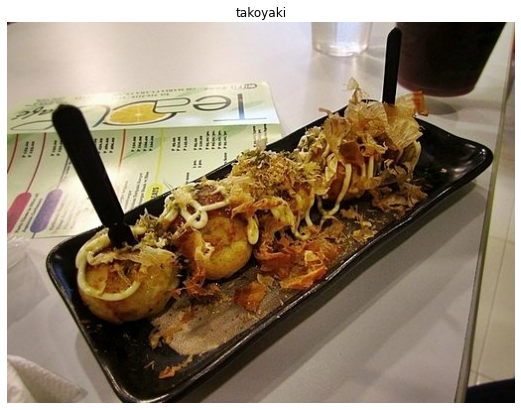

In [14]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

Neural networks perfomr best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from TensorFlow Datasets) comes like this. 

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it ot your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, Tensorflow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better.

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretraained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `uint8` to `float32`

In [15]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple



In [19]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: \nDatatype: {image.dtype}")
print(f"Image after preprocessing:\n{preprocess_img[:2]}...,\nShape:{preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 54  30  26]
  [ 57  33  29]
  [ 72  49  43]
  ...
  [192 184 163]
  [190 179 159]
  [181 169 147]]

 [[ 51  28  22]
  [ 60  37  31]
  [ 81  58  52]
  ...
  [191 183 162]
  [189 176 157]
  [176 164 142]]]..., 
Shape: 
Datatype: <dtype: 'uint8'>


TypeError: ignored

## Batch & Prepare Datasets

We're now going to make our data input pipeline run really fast.


In [21]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# sHUFFLE TRAIN_DATA AND TURN IT INTO BATCHES AND PREFETCH IT )LOAD IT FASTER)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard calback to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [23]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      ave_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision training 

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance

In [24]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

In [25]:
!nvidia-smi

Fri Mar  3 13:32:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    31W /  70W |    335MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [26]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [28]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # makes sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compilt the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


16705208/16705208 [==============================] - 0s 0us/step


In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype policies (are we using mixed precision?)

In [30]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not? (if `False`, the wights are frozen)
* `layer.dtype`: the datatype a layer stores it variables in 
* `layer.dtype_policy`: the datatype policy a layer computes on its variables with

In [33]:
from keras.applications import EfficientNetB0
for layer in base_model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [34]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230303-142725
Epoch 1/3
2368/2368 [==============================] - 215s 82ms/step - loss: 1.7186 - accuracy: 0.5815 - val_loss: 1.1363 - val_accuracy: 0.6944
Epoch 2/3
2368/2368 [==============================] - 208s 87ms/step - loss: 1.1994 - accuracy: 0.6887 - val_loss: 1.0295 - val_accuracy: 0.7195
Epoch 3/3
2368/2368 [==============================] - 207s 86ms/step - loss: 1.0548 - accuracy: 0.7236 - val_loss: 0.9883 - val_accuracy: 0.7275


In [35]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 62s 78ms/step - loss: 0.9966 - accuracy: 0.7296


[0.99662184715271, 0.7296237349510193]

## Off to you...

We've covered a lot of ground so far but since this is a milestone project, it's time f you to takeover.

More specifically, your challenge is to complete the TEMPLATE version of 07 to obtain a computer vision model (building off the one we've built in this notebook) to beat the DeepFood Paper.

In other words, you're going to creat Food Vision Big.

You can find the TEMPLATE notebook here: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/TEMPLATE_07_food_vision_milestone_project_1.ipynb


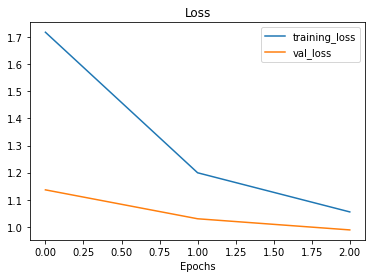

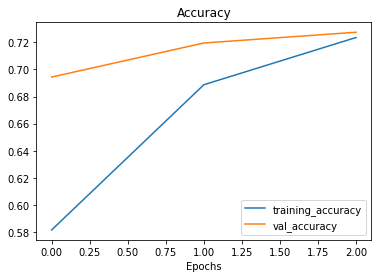

In [36]:
# Check loss curves
from helper_functions import plot_loss_curves
plot_loss_curves(history_101_food_classes_feature_extract)

## Lets Fine tune to model

The three experiments that I would like to try with an additional 3 epochs:
1. no changes in fine-tuning
2. Fine tuning bottom 5 layers
3. Fine tuning bottome 10 layers

The goal is to reuse the model checkpoint to determine which weights had the best growth.

In [42]:
# What would the model look like after training an additional 3 epochs?
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [43]:
fine_tune_epoch = 6
history_101_food_classes_no_fine_tune = model.fit(train_data,
                                                  epochs=fine_tune_epoch,
                                                  steps_per_epoch=len(train_data),
                                                  validation_data=test_data,
                                                  validation_steps=0.15 * len(test_data),
                                                  initial_epoch=history_101_food_classes_feature_extract.epoch[-1],
                                                  callbacks=create_tensorboard_callback(dir_name="training_logs",
                                                                                        experiment_name="food101_no_fine_tune_last_6"))

Saving TensorBoard log files to: training_logs/food101_no_fine_tune_last_6/20230303-154858
Epoch 3/6
2368/2368 [==============================] - 229s 92ms/step - loss: 0.8907 - accuracy: 0.7720 - val_loss: 0.9624 - val_accuracy: 0.7340
Epoch 4/6
2368/2368 [==============================] - 213s 89ms/step - loss: 0.8742 - accuracy: 0.7771 - val_loss: 0.9495 - val_accuracy: 0.7403
Epoch 5/6
2368/2368 [==============================] - 225s 94ms/step - loss: 0.8630 - accuracy: 0.7803 - val_loss: 0.9559 - val_accuracy: 0.7366
Epoch 6/6
2368/2368 [==============================] - 241s 101ms/step - loss: 0.8538 - accuracy: 0.7827 - val_loss: 0.9521 - val_accuracy: 0.7384


In [44]:
# Evaluate the model
not_fine_tuned_model = model.evaluate(test_data)
not_fine_tuned_model

790/790 [==============================] - 55s 70ms/step - loss: 0.9573 - accuracy: 0.7396


[0.9573014974594116, 0.7396435737609863]

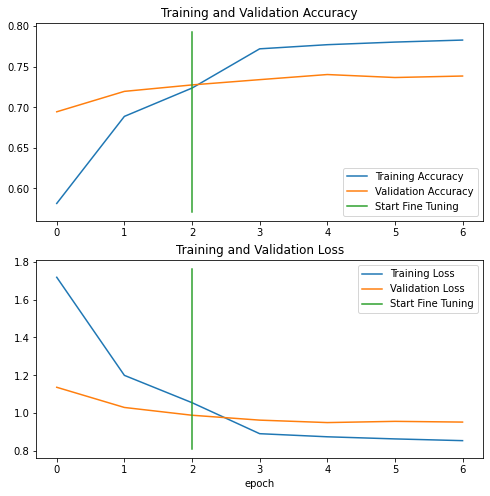

In [45]:
# How does the model look so far?
from helper_functions import compare_historys
compare_historys(original_history=history_101_food_classes_feature_extract,
                 new_history=history_101_food_classes_no_fine_tune,
                 initial_epochs=3)

### Lets try unreezing 5 layers

In [46]:
# Unfreeze all layers in model
base_model.trainable = True
# Refreeze all layers besides 5
for layers in base_model.layers[:-5]:
  layers.trainable = False

# Check if layers changed
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
global_average_pooling2d True
dense True
softmax_float32 True


In [47]:
# What would the model look like after training an additional 3 epochs?
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [48]:
history_101_food_classes_fine_tune_5_layers = model.fit(train_data,
                                                        epochs=fine_tune_epoch,
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=0.15 * (len(test_data)),
                                                        initial_epoch=history_101_food_classes_feature_extract.epoch[-1],
                                                        callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                               experiment_name="food101_fine_tune_5_layers_last_6")])

Saving TensorBoard log files to: training_logs/food101_fine_tune_5_layers_last_6/20230303-160813


Epoch 3/6
2368/2368 [==============================] - 253s 100ms/step - loss: 0.8422 - accuracy: 0.7759 - val_loss: 0.9136 - val_accuracy: 0.7466
Epoch 4/6
2368/2368 [==============================] - 218s 91ms/step - loss: 0.7247 - accuracy: 0.8075 - val_loss: 0.8988 - val_accuracy: 0.7500
Epoch 5/6
2368/2368 [==============================] - 225s 94ms/step - loss: 0.6398 - accuracy: 0.8304 - val_loss: 0.8846 - val_accuracy: 0.7529
Epoch 6/6
2368/2368 [==============================] - 198s 83ms/step - loss: 0.5673 - accuracy: 0.8519 - val_loss: 0.8846 - val_accuracy: 0.7550


In [ ]:
fine_tuned_5_layer_model = model.evaluate(test_data)
fine_tuned_5_layer_model

In [ ]:
# How does the model look so far?
from helper_functions import compare_historys
compare_historys(original_history=history_101_food_classes_feature_extract,
                 new_history=history_101_food_classes_fine_tune_5_layers,
                 initial_epochs=3)

### Lets try unfreezing 10 layers

In [51]:
# First we need to reset the weights of the model
model.load_weights("/content/model_checkpoints/cp.ckpt.index")

AssertionError: ignored

In [52]:
# Evaluate weights
model.evaluate(test_data)

790/790 [==============================] - 56s 70ms/step - loss: 0.9966 - accuracy: 0.7296


[0.9966230392456055, 0.7296237349510193]

In [53]:
# Check if it matches the previous weights
results_feature_extract_model

[0.99662184715271, 0.7296237349510193]

In [54]:
# Unfreeze all layers in model
base_model.trainable = True
# Refreeze all layers besides 10
for layers in base_model.layers[:-10]:
  layers.trainable = False

# Check if layers changed
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
global_average_pooling2d True
dense True
softmax_float32 True


In [55]:
# What would the model look like after training an additional 3 epochs?
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
history_101_food_classes_fine_tune_10_layers = model.fit(train_data,
                                                        epochs=fine_tune_epoch,
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=0.15 * (len(test_data)),
                                                        initial_epoch=history_101_food_classes_feature_extract.epoch[-1],
                                                        callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                               experiment_name="food101_fine_tune_10_layers_last_6")])

Saving TensorBoard log files to: training_logs/food101_fine_tune_10_layers_last_6/20230303-163415
Epoch 3/6
 773/2368 [========>.....................] - ETA: 2:05 - loss: 0.8950 - accuracy: 0.7597

In [ ]:
# How did the model do?
fine_tuned_10_layer_model = model.evaluate(test_data)
fine_tuned_10_layer_model

In [ ]:
# Compare histories
from helper_functions import compare_historys
compare_historys(original_history=history_101_food_classes_feature_extract,
                 new_history=history_101_food_classes_fine_tune_10_layers,
                 initial_epochs=3)

## Evaluate Model

In [ ]:
pred_probs = model.predict(test_data, verbose=1)
pred_probs[:10]

In [ ]:
# Get pred classes of each prediction
pred_classes = pred_probs.argmax(axis=1)
pred_classes

In [ ]:
# Get test labels
y_labels = []
for image, label in test_data.unbatch():
  y_labels.append(label.numpy().argmax())
y_labels[:10]

## Let's Create a confusion Matrix

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
# Get list of class_names
class_names = test_data.class_names
class_names[:10]

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_preds=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20)

## More evaluations